# Imports et setup technique

In [1]:
import pandas as pd
from IPython.display import display
idx = pd.IndexSlice
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
mcolorpalette = list(mcolor.TABLEAU_COLORS.values())
import matplotlib.dates as mdates
from pathlib import Path
persist_path = Path('..') / 'persist'
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure
from bokeh.models import CDSView, ColumnDataSource, GroupFilter, FactorRange, HoverTool
from bokeh.models.annotations import BoxAnnotation
from bokeh.layouts import row, column
from bokeh.models.formatters import NumeralTickFormatter

from functools import partial
from datetime import datetime, date
import sys
project_root = str(Path(sys.path[0]).parents[0].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)
from importlib import reload
from scripts.utils import compute_zscores, process_df, compute_distribution
import scripts.utils as utils

Loading BokehJS ...

# Chargement des données

## Données de base client

In [2]:
cltfields = {
             'client': 'object',
             'V': 'object',
             'groupecompte': 'object',
             'nom': 'object',
             'postalcode': 'object',
             'seg1': 'object',
             'seg2': 'object',
             'seg3': 'object',
             'seg4': 'object',
             'cat': 'object',
             'sscat': 'object',
#              'saiso': 'bool',
             'surcat': 'object',
#              'ecom': 'bool', 
             'sectact': 'object',
             'canal': 'object', 
             'orgacom': 'object', 
             'grpclt1': 'object',
             'grpclt2': 'object',
             'grpclt3': 'object',
             'grpclt4': 'object',
             'grpclt5': 'object',
             'agence': 'object', 
             'condexp': 'object', 
             'pricetype': 'object', 
             'relationtype': 'object',
             'pilcom': 'object',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

clt_fields2 = {
             'client': 'object',
             'V': 'category',
             'groupecompte': 'category',
             'nom': 'object',
             'postalcode': 'category',
             'seg1': 'category',
             'seg2': 'category',
             'seg3': 'category',
             'seg4': 'category',
             'cat': 'category',
             'sscat': 'category',
#              'saiso': 'bool',
             'surcat': 'category',
#              'ecom': 'bool', 
             'sectact': 'category',
             'canal': 'category', 
             'orgacom': 'category', 
             'grpclt1': 'category',
             'grpclt2': 'category',
             'grpclt3': 'category',
             'grpclt4': 'category',
             'grpclt5': 'category',
             'agence': 'category', 
             'condexp': 'category', 
             'pricetype': 'category', 
             'relationtype': 'category',
             'pilcom': 'category',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

filenames = [
    'ref_clt.csv',
    'ref_clt2.csv',
    'export2BRE_clt.csv',
    'exportcomp1ALO.csv',
]
paths = [Path('..') / 'data' / 'clt' / 'small' / filename for filename in filenames]

df_clts = [
    pd.read_csv(path,
                sep=';',
                encoding='latin1', 
                dtype=cltfields,
                converters={'saiso': lambda x: True if x == 'YES' else False, 
                            'ecom': lambda x: True if x == 'X' else False},
                ) for path in paths
]

df_clt = pd.concat(df_clts, axis=0)
for field, dtype in clt_fields2.items(): 
    if field not in df_clt.columns:
        print(field)
df_clt = df_clt.astype(clt_fields2)
df_clt.sample(5)

,client,V,groupecompte,nom,postalcode,seg1,seg2,seg3,seg4,cat,...,grpclt5,agence,condexp,pricetype,relationtype,pilcom,hier4,hier3,hier2,hier1
10861,93821,A,ZCLT,HOTEL KYRIAD COLMAR,68000,Z3,Z5,ZK,ZG,ZT,...,051,1MUL,ST,T1,NDI,NTL,10324,10325,10885,10892
12510,125551,A,ZCLT,SOGERES DR FISCHER,54700,Z3,Z4,ZJ,ZF,ZP,...,051,1NAN,ST,NaN,DIR,BIG,11059,123616,123617,123652
22573,3014372,A,ZCOL,PERSO HOP ST JACQUES,67560,Z4,Z0,ZQ,ZO,Z5,...,051,1STR,ST,T1,NDI,RGL,NaN,NaN,NaN,NaN
44412,272533,A,ZCLT,VILLAGE DES GATINES,87300,Z3,Z4,ZI,ZB,ZO,...,L31,1LIM,ST,T4,NDI,RGL,10651,10652,10653,234513
13413,164724,A,ZHIE,EDA - LOT 7,93500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# remove emppty client codes
df_clt = df_clt.loc[~df_clt.client.isna()]

# zero pad numeric clients codes
num_clt_mask = df_clt['client'].str.isnumeric()
df_clt.loc[num_clt_mask, 'client'] = df_clt.loc[num_clt_mask, 'client'].str.zfill(10)

#remove duplicated clients
print(f'Clients count before cleansing : {df_clt.client.count()}')
print(f"Duplicated clients before cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")
df_clt = df_clt.loc[~(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False) & df_clt.sectact.isna())]
print(f"Clients count after cleansing : {df_clt.client.count()}")
print(f"Duplicated clients after cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")

# set the index
df_clt.set_index(['orgacom', 'client'], inplace=True, drop=True)

Clients count before cleansing : 104640
Duplicated clients before cleansing: 4634
Clients count after cleansing : 102323
Duplicated clients after cleansing: 0


In [4]:
df_clt.sample(5)

,,V,groupecompte,nom,postalcode,seg1,seg2,seg3,seg4,cat,sscat,...,grpclt5,agence,condexp,pricetype,relationtype,pilcom,hier4,hier3,hier2,hier1
orgacom,client,,,,,,,,,,,,,,,,,,,,,
1SOU,0000274350,A,ZCLT,DU BEAU DU BON,87220,Z3,Z5,ZK,ZG,ZY,ZY,...,051,1LIM,ST,T2,NDI,RGL,NaN,NaN,NaN,NaN
1ALO,0000158922,A,ZCLT,L'ATELIER PATISSERIE,88400,Z3,Z5,ZK,ZG,ZY,ZY,...,051,1NAN,ST,T1,NDI,RGL,NaN,NaN,NaN,NaN
2BRE,0000053489,A,ZCLT,COTE RIVE,14800,Z3,Z5,ZK,ZG,ZS,ZK,...,051,2CAL,ST,T2,NDI,RGL,NaN,NaN,NaN,NaN
1LRO,0000100026,A,ZCLT,BOULANGERIE LE PAIN DU PORT,66660,Z3,Z5,ZK,ZG,ZW,ZT,...,051,1PER,ST,T1,DIR,RGL,99556,99557,99558,99559
1ALO,0000026914,A,ZCHN,CGF CTRE PENITENCIER CANTINE,54320,Z3,Z4,ZJ,ZF,ZR,ZH,...,051,1NAN,ST,NaN,DIR,BIG,10337,10339,10343,10351


In [5]:
if sum(df_clt.index.duplicated()):
    raise RuntimeError('Something went wrong on the client dataframe! Some indices are duplicated!')

In [6]:
print(*df_clt.groupecompte.unique())

ZCLT ZFAC ZCHN ZCFR ZPER ZLIV ZCRC ZHIE ZCOL ZREG ZCTR ZCFE ZCAC ZCFG ZCPP ZCRI ZCRM ZGPE 0100 ZCPD ZCAB


Libellés des segments clients :

In [7]:
path = Path('..') / 'data' / 'libelles_segments.csv'
lib_seg = pd.read_csv(path,
                      sep=';',
                      encoding='latin1',
                      header=None,
                      names=['level', 'code', 'designation'],
                      index_col=['level', 'code']
                     )
lib_seg

designation
level code                      
1     Z1            Distribution
      Z3                     RHD
      Z4                  Divers
2     Z0       Autres clientèles
      Z1                     GMS
...                          ...
6     ZV          Gare/ Aéroport
      ZW     Rest. sur autoroute
      ZX    Station service btiq
      ZY      Traiteur Réception
      ZZ       Traiteur Boutique

[149 rows x 1 columns]

In [8]:
df_clt.to_pickle(persist_path / 'small_clt.pkl')
lib_seg.to_pickle(persist_path / 'small_lib_seg.pkl')

## Historiques de vente

In [9]:
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES.csv'
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES_v2.csv'
path_list = [
    Path('..') / 'data' / 'small' / filename 
    for filename in [
        'EXTRACT_LIGNES_VENTES_V3.csv',
        'EXTRACTION_2BRE.csv'
    ]
]
fields = {'orgacom': pd.CategoricalDtype(['1SOU', '1ALO', '1LRO', '2BRE'], ordered=True),
          'month': 'category',
          'week': 'category',
          'date': 'object',
          'pricetype': 'category',
          'client': 'object',
          'doctype': 'category',
          'origin': pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB', '#', 'SCHR', 'TELE',
                                         'MUEN', 'FRN', 'DFUE'], ordered=True),
          'salesgroup': 'category',
          'material': 'object',
          'brutrevenue': 'float',
          'brutrevcur': 'category', 
          'netrevenue': 'float', 
          'netrevcur': 'category',
          'weight': 'float',
          'weightunit': 'category',
          'margin': 'float', 
          'margincur': 'category', 
          'marginperkg': 'float',
         }

In [10]:
%%time
data = [pd.read_csv(path,
                   sep=';',
                   header=None,
                   names=list(fields.keys()),      
                   dtype=fields, 
                   parse_dates=['date'],
                  ) for path in path_list]
data = pd.concat(data, axis=0)
data.sample(5)

CPU times: user 1min 7s, sys: 9.39 s, total: 1min 17s
Wall time: 1min 17s


,orgacom,month,week,date,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,margin,margincur,marginperkg
694512,2BRE,201710,201742,2017-10-16,ZTCE,0000115459,ZC10,EDI,F58,000000000000028715,20.86,EUR,17.96,EUR,5.000,KG,4.46,EUR,0.89
19137623,1SOU,201904,201916,2019-04-19,ZTCE,0000070244,ZC10,EDI,782,000000000000087941,85.12,EUR,79.79,EUR,70.000,KG,17.17,EUR,0.25
3233610,2BRE,201811,201845,2018-11-07,ZTCE,0000151087,ZC10,TV,A02,000000000000023167,13.22,EUR,12.29,EUR,9.500,KG,2.24,EUR,0.24
8878301,1ALO,201805,201819,2018-05-09,ZTCE,0000148696,ZC10,TV,650,000000000000008748,18.17,EUR,14.70,EUR,19.500,KG,0.59,EUR,0.03
1899592,1SOU,201708,201735,2017-08-28,ZTCE,0000196812,ZC10,EDI,782,000000000000019388,12.40,EUR,9.74,EUR,1.333,KG,1.09,EUR,0.82


In [11]:
print(f"Nombre de lignes d'historique de vente : {len(data)}")

Nombre de lignes d'historique de vente : 39793822


## Filtres sur les données
### Filtre sur les types de documents
Définition des types de poste valides et invalides.
PAR CONTRE, on ne filtre plus les documents de type avoir !

In [12]:
valid_doctypes = ['ZC01', 'ZC02', 'ZC10']
invalid_doctypes = ['ZR01', 'ZR02', 'ZA01', 'ZA02', 'ZA03', 'ZA04', 'ZC20']
doctypes = valid_doctypes + invalid_doctypes

In [13]:
if len(data.loc[~data.doctype.isin(doctypes)]) > 0:
    raise RuntimeError(f'An unexpected doctype has been encountered: '
                       f'{data.loc[~data.doctype.isin(doctypes), "doctype"].iloc[0]}!')

In [14]:
    order_doctype_mask = data.doctype.isin(valid_doctypes)

## Nettoyage des poids / CA à zéro
On contrôle d'abord qu'il n'y a pas de ligne de commande avec un poids à zéro mais un CA associé

In [15]:
if len(data.loc[order_doctype_mask & (data.weight == 0) & (data.brutrevenue != 0)]) > 0:
    print('Some sales have no weight but have brut revenue!')
data.loc[order_doctype_mask & (data.weight == 0) & (data.brutrevenue != 0), 'material'].unique()

Some sales have no weight but have brut revenue!


array(['FL ACCOR', 'FL39860', 'FL66446', 'FC42378', '000000000000156486',
       'FC34504', 'FC34502', 'FC34503'], dtype=object)

On contrôle que le CA brut des commandes est toujours positif.

In [16]:
if len(data.loc[order_doctype_mask & (data.brutrevenue < 0)]) > 0: 
    raise RuntimeError('Some sales have negative brut revenue!')

## Calcul des indicateurs manquants

In [17]:
data['purchcost'] = data.brutrevenue - data.margin
data['purchcostperkg'] = data.purchcost / data.weight
data['PMVK'] = data.brutrevenue / data.weight
data['marginpercent'] = (data.margin / data.brutrevenue).replace({np.inf: np.nan, -np.inf: np.nan})

## Définition des formats des indicateurs

In [18]:
formats = utils.formats

## Nettoyage des avoirs
### Constat d'erreurs et corrections sur les prix
Il apparaît que certaines erreurs sur les prix qui faussent l'analyse ont eu un impact fort sur les indicateurs :

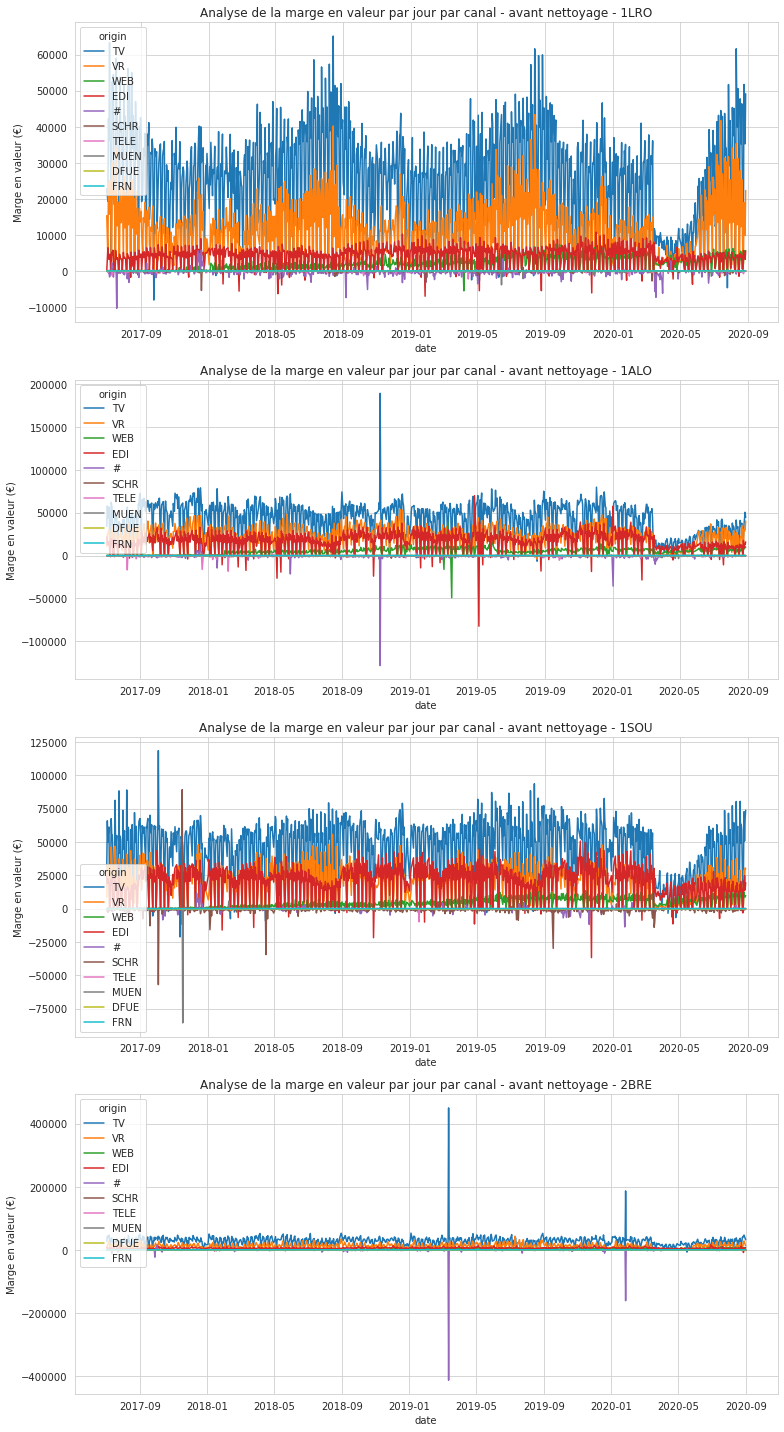

In [19]:
mult_origins_order = ['TV', 'VR', 'WEB', 'EDI', '#', 'SCHR', 'TELE', 'MUEN', 'DFUE', 'FRN']

nrows = len(data.orgacom.unique())
fig, axs = plt.subplots(figsize = (11, 5 * nrows), nrows=nrows)
orgacoms = data.orgacom.unique().tolist()
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .rolling(1, win_type='triang')
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in orgacoms]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_,
                 x='date',
                 y='margin',
                 hue='origin',
                 hue_order=mult_origins_order,
                 ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - avant nettoyage - {orgacoms[i]}')
    axs[i].set_ylabel('Marge en valeur (€)')
fig.tight_layout()

On voit 3 gros pics négatifs qui sont des corrections d'erreur sur les prix, mais pas affectés au canal correspondant.

### Calcul d'une table des avoirs, aggrégée

In [20]:
myfields = ['orgacom',
            'doctype',
            'date',
            'origin',
            'material',
            'client',
            'brutrevenue',
            'weight',
            'PMVK',
            'marginperkg',
            'margin',
            'purchcost',
            'purchcostperkg']

In [21]:
len_before = len(data.loc[data.doctype.isin(['ZA01', 'ZA02'])])
brutrev_before = data.loc[data.doctype.isin(['ZA01', 'ZA02']), 'brutrevenue'].sum()

In [22]:
print('Avant nettoyage')
print(f"Nombre d'avoirs ZA01 et ZA02 : {len_before}")
print(f"CA représenté par ces avoirs : {brutrev_before: .2f} €")

Avant nettoyage
Nombre d'avoirs ZA01 et ZA02 : 136817
CA représenté par ces avoirs : -4880871.31 €


In [23]:
data.orgacom.unique()

['1LRO', '1ALO', '1SOU', '2BRE']
Categories (4, object): ['1SOU' < '1ALO' < '1LRO' < '2BRE']

In [24]:
data.index.names

FrozenList([None])

In [26]:
%%time
dfs = []
for suc in data.orgacom.unique():
    print(f'Début du traitement pour {suc}')
    to_process = data.loc[data.orgacom == suc]
    data = data.loc[data.orgacom != suc]
    dfs.append(process_df(to_process))

Début du traitement pour 1LRO
Evolution des indicateurs pendant le traitement : 
margin         7.450581e-08
brutrevenue    2.980232e-07
weight         0.000000e+00
dtype: float64
Début du traitement pour 1ALO
Evolution des indicateurs pendant le traitement : 
margin        -1.490116e-08
brutrevenue    2.980232e-07
weight        -1.192093e-07
dtype: float64
Début du traitement pour 1SOU
Evolution des indicateurs pendant le traitement : 
margin        -2.980232e-08
brutrevenue    0.000000e+00
weight         1.639128e-07
dtype: float64
Début du traitement pour 2BRE
Evolution des indicateurs pendant le traitement : 
margin        -4.470348e-08
brutrevenue    1.192093e-07
weight        -2.831221e-07
dtype: float64
CPU times: user 4min 48s, sys: 1min 14s, total: 6min 2s
Wall time: 6min 2s


In [27]:
data = pd.concat(dfs, axis=0)
del(dfs)
data.sample(10)

,orgacom,month,week,date,pricetype,client,doctype,origin,salesgroup,material,...,netrevcur,weight,weightunit,margin,margincur,marginperkg,purchcost,purchcostperkg,PMVK,marginpercent
2690726,2BRE,201808,201833,2018-08-17,ZTCR,0000207819,ZC10,VR,998,000000000000183983,...,EUR,1.00,KG,1.12,EUR,1.12,1.21,1.210000,2.330000,0.480687
6672172,1ALO,201902,201906,2019-02-07,ZTCR,0000021061,ZC10,TV,H21,000000000000137364,...,EUR,2.40,KG,3.15,EUR,1.31,3.33,1.387500,2.700000,0.486111
10295825,1SOU,201910,201943,2019-10-27,ZTCE,0000233426,ZC10,EDI,809,000000000000099502,...,EUR,0.00,KG,0.03,EUR,0.00,-0.03,-inf,NaN,NaN
3726908,2BRE,201901,201904,2019-01-22,ZTCN,0000072698,ZC10,TV,966,000000000000151859,...,EUR,0.60,KG,2.46,EUR,4.10,9.03,15.050000,19.150000,0.214099
5932168,1ALO,201812,201849,2018-12-03,ZTCN,0000138043,ZC10,EDI,M98,000000000000098382,...,EUR,22.44,KG,53.37,EUR,2.38,322.04,14.351159,16.729501,0.142165
275053,1ALO,201707,201730,2017-07-27,ZTCR,SL001P,ZC10,TV,#,000000000000068210,...,EUR,24.75,KG,2.13,EUR,0.09,24.31,0.982222,1.068283,0.080560
5620886,1ALO,201811,201845,2018-11-07,ZTG,0000024596,ZC10,VR,M33,000000000000187562,...,EUR,3.25,KG,20.84,EUR,6.41,8.66,2.664615,9.076923,0.706441
4562453,1ALO,201808,201833,2018-08-13,ZTCE,0000020831,ZC10,EDI,595,000000000000095292,...,EUR,4.80,KG,3.61,EUR,0.75,20.04,4.175000,4.927083,0.152643
13191307,1SOU,202008,202033,2020-08-14,ZTM,0000177910,ZC10,WEB,801,000000000000028567,...,EUR,3.24,KG,1.58,EUR,0.49,24.75,7.638889,8.126543,0.060008
4744485,1ALO,201808,201834,2018-08-26,ZTCE,0000175915,ZC10,EDI,632,000000000000044846,...,EUR,0.00,KG,-0.02,EUR,0.00,0.02,inf,NaN,NaN


In [28]:
len_after = len(data.loc[data.doctype.isin(['ZA01', 'ZA02'])])
brutrev_after = data.loc[data.doctype.isin(['ZA01', 'ZA02']), 'brutrevenue'].sum()

In [29]:
print('Après nettoyage')
print(f"Nombre d'avoirs ZA01 et ZA02 : {len_after}. "
      f"Evolution : {len_before - len_after} lignes retraitées "
      f"soit : {(len_before - len_after)/len_before:.2%}")
print(f"CA représenté par ces avoirs : {brutrev_after: .2f} €. "
      f"Evolution : {brutrev_after - brutrev_before:.2f} € retraités "
      f"soit : {(brutrev_before - brutrev_after)/brutrev_before:.2%}")

Après nettoyage
Nombre d'avoirs ZA01 et ZA02 : 119841. Evolution : 16976 lignes retraitées soit : 12.41%
CA représenté par ces avoirs : -3229336.34 €. Evolution : 1651534.97 € retraités soit : 33.84%


On peut plotter les indicateurs après nettoyage :

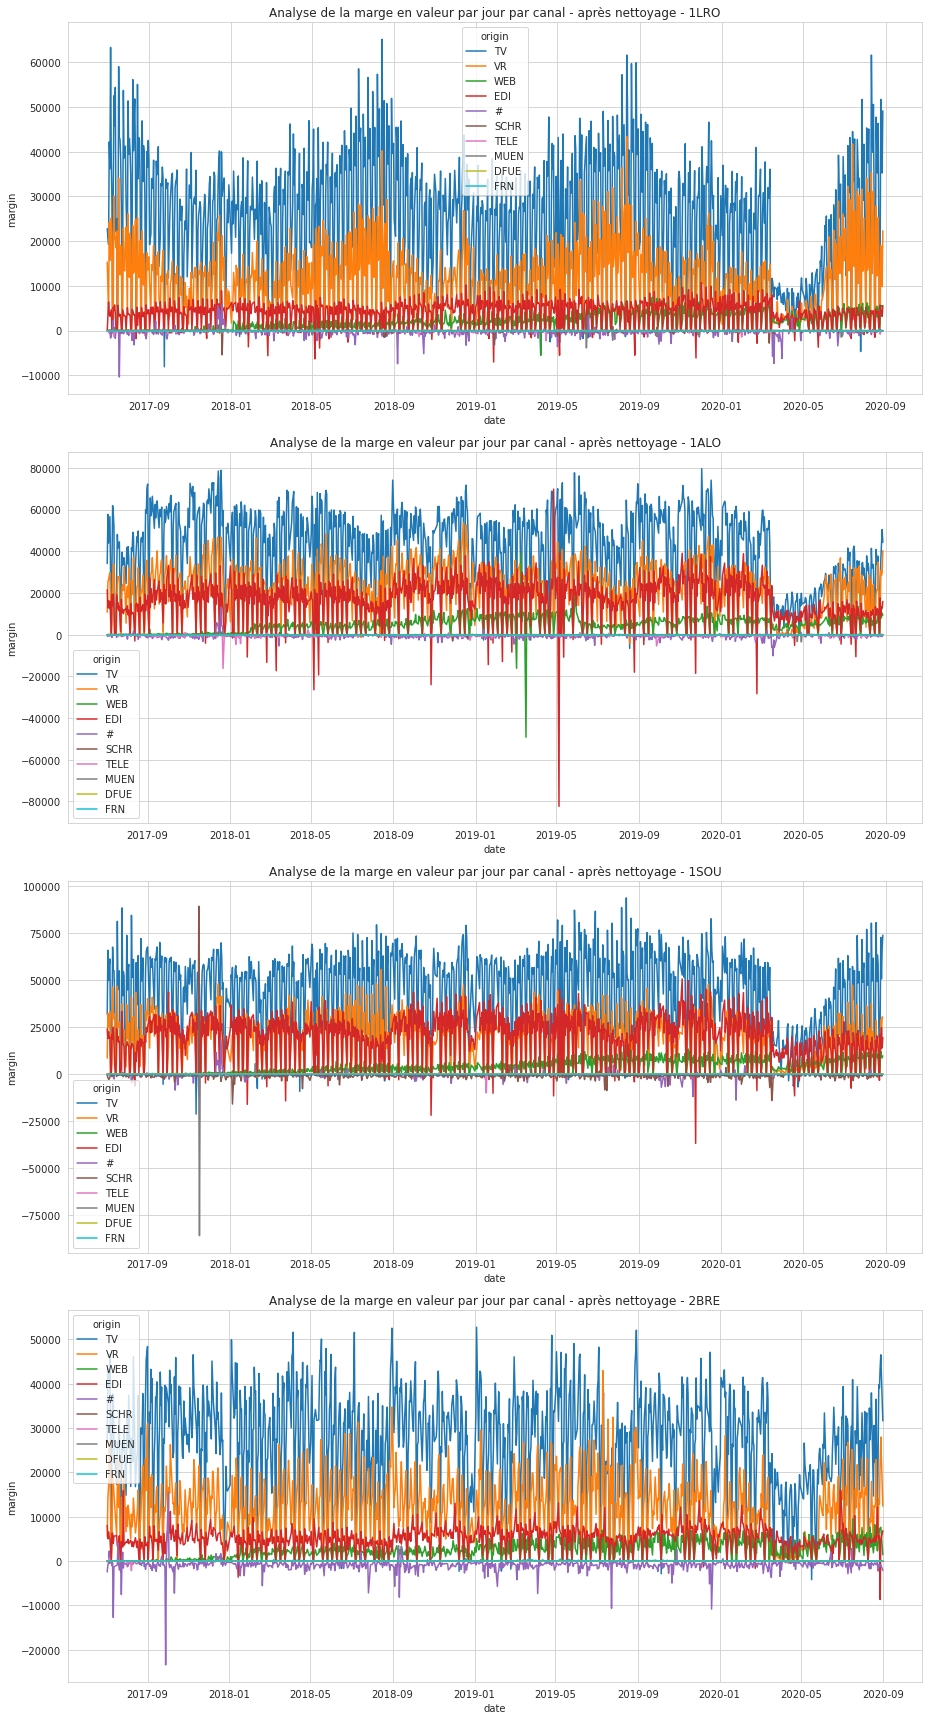

In [30]:
nrows = len(data.orgacom.unique())
fig, axs = plt.subplots(figsize = (13, 6 * nrows), nrows=nrows)
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .fillna(0.)
        .rolling(1, win_type='triang')
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in data.orgacom.unique()]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_,
                 x='date',
                 y='margin',
                 hue='origin',
                 hue_order=mult_origins_order,
                 ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - après nettoyage - {orgacoms[i]}')
fig.tight_layout()

In [31]:
data.to_pickle(persist_path / 'small_data.pkl')

## Affichage des indicateurs par succursale et canal

In [32]:
data = pd.read_pickle(persist_path / 'small_data.pkl')

In [33]:
indicator_map = {
    'Marge (€)': 'margin',
    'CA brut (€)': 'brutrevenue',
    'Tonnage (kg)': 'weight',
}

CPU times: user 20.3 s, sys: 7.92 s, total: 28.2 s
Wall time: 28 s


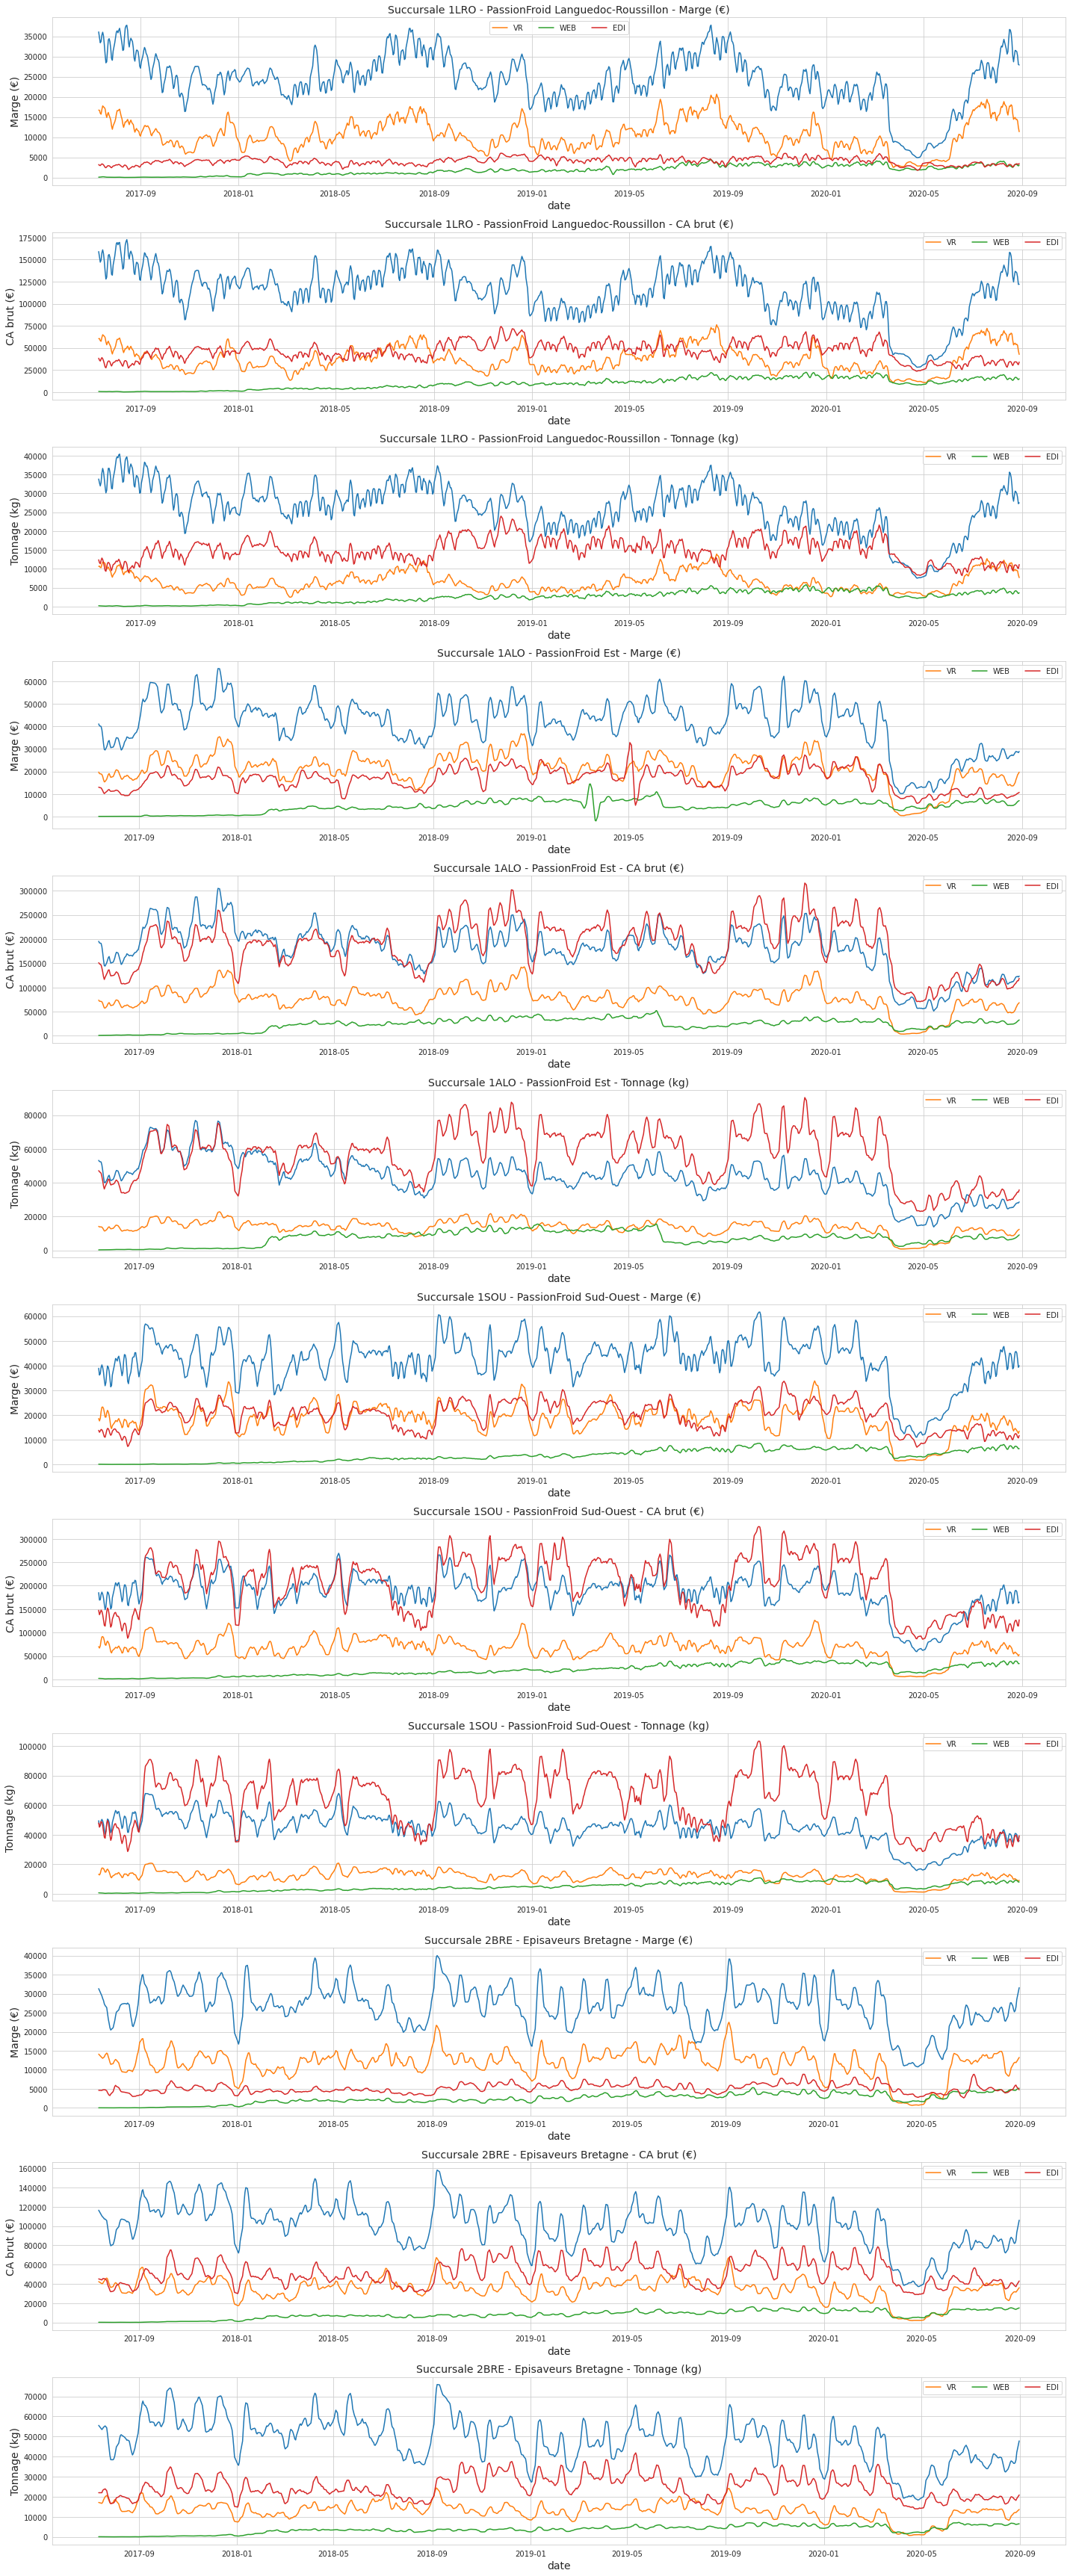

In [34]:
%%time
SV = data['orgacom'].unique()
indicators = ['weight', 'brutrevenue', 'margin']
roll_width = 10
win_type = 'triang'
fig, axs = plt.subplots(figsize=(20, 4 * len(SV)* len(indicator_map)),
                        nrows=len(SV) * len(indicator_map),
#                         squeeze=False,
                       )

for i, suc in enumerate(SV):
    for j, indicator in enumerate(indicator_map):
        
        data_to_plot = (
            data.loc[(data.orgacom == suc) & data.origin.isin(['TV', 'VR', 'WEB', 'EDI'])]
                .groupby(['date', 'origin'], observed=True)[indicator_map[indicator]]
                .sum()
                .unstack('origin')
                .fillna(0.)
                .rolling(roll_width, win_type=win_type)
                .mean()
                .stack('origin')
                .rename(indicator)
                .sort_index()
                .reset_index())
        sns.lineplot(data=data_to_plot,
                     x='date',
                     y=indicator,
                     hue='origin',
                     hue_order=mult_origins_order[:4],                     
                     ax=axs[i * len(indicator_map) + j])
        handles, labels = axs[i * len(indicator_map) + j].get_legend_handles_labels()
        handles = handles[1:]
        labels = labels[1:]
        axs[i * len(indicator_map) + j].legend(handles, labels, ncol=4, )
        axs[i * len(indicator_map) + j].set_title(f'Succursale {utils.lib(suc)} - {indicator}', fontsize=14)
        axs[i * len(indicator_map) + j].xaxis.label.set_fontsize(14)
        axs[i * len(indicator_map) + j].yaxis.label.set_fontsize(14)
        
fig.tight_layout()

## Filtration des canaux "exotiques"

In [35]:
origin2_cat = pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB'], ordered=True)
data['origin2'] = data.origin.astype(origin2_cat)

## Calcul du canal majoritaire par jour

In [36]:
aggfuncs = {
    'margin': 'sum', 
    'brutrevenue': 'sum',
    'weight': 'sum',
    'origin2': 'size',
}
orders = (
    data.loc[(data.doctype == 'ZC10') & (data.weight > 0.) & (data.brutrevenue > 0.)]
        .groupby(['orgacom', 'date', 'client', 'origin2'], observed=True)
        .agg(aggfuncs)
        .rename({'origin2': 'linecount'}, axis=1)
)
print(f'{len(orders)} records in order dataframe before canal deduplication')
orders

2751677 records in order dataframe before canal deduplication


margin  brutrevenue   weight  linecount
orgacom date       client     origin2                                         
1SOU    2017-07-03 0000065940 TV        31.16        84.01    5.501          9
                   0000065945 TV         6.02        23.69    3.734          2
                   0000065975 TV        25.15        97.40   13.718          1
                   0000065998 TV         4.12         8.56    1.000          1
                   0000066014 TV        17.89        48.30    5.000          1
...                                       ...          ...      ...        ...
2BRE    2020-08-31 0000285226 VR         1.38        10.16   10.000          2
                   SL001W     TV        89.34       555.25  180.000          4
                   SL0041     TV        28.42      1470.00    7.200          1
                   SL0075     TV        12.76        95.03   15.615         11
                   SL009N     TV        10.51        75.03   40.500          1

[2751677 rows x 4 columns]

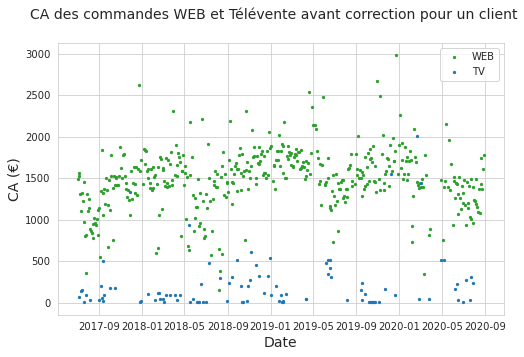

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[2],
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[0],
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('CA (€)', fontsize=14)
fig.suptitle('CA des commandes WEB et Télévente avant correction pour un client', fontsize=14)
ax.legend()


On considère le canal de la commande comme étant le canal qui représente le plus en poids pour un jour donné.

In [38]:
df_before = orders[['margin', 'brutrevenue', 'weight']].groupby('origin2').agg(['sum', 'size'])
df_before

margin            brutrevenue                 weight         
                  sum     size           sum     size           sum     size
origin2                                                                     
TV       1.317671e+08  1500784  5.656508e+08  1500784  1.561315e+08  1500784
VR       6.039799e+07   542186  2.090946e+08   542186  4.364318e+07   542186
EDI      4.404536e+07   602003  4.681359e+08   602003  1.542627e+08   602003
WEB      1.190551e+07   106704  5.908175e+07   106704  1.764510e+07   106704

In [39]:
major_canal = orders['weight'].unstack(fill_value=0.).idxmax(axis=1).rename('origin2')
major_canal

orgacom  date        client    
1SOU     2017-07-03  0000065940     TV
                     0000065945     TV
                     0000065975     TV
                     0000065998     TV
                     0000066014     TV
                                  ... 
2BRE     2020-08-31  0000282373    EDI
                     0000283953    EDI
                     0000284089     TV
                     0000284540     TV
                     0000284735     VR
Name: origin2, Length: 2444326, dtype: object

In [40]:
orders = orders.groupby(level=[0, 1, 2], observed=True).sum().join(major_canal)
del(major_canal)
order_count = len(orders)
print(f'{order_count} records in order dataframe after canal deduplication')
orders

2444326 records in order dataframe after canal deduplication


margin  brutrevenue   weight  linecount origin2
orgacom date       client                                                     
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9      TV
                   0000065945    6.02        23.69    3.734          2      TV
                   0000065975   25.15        97.40   13.718          1      TV
                   0000065998    4.12         8.56    1.000          1      TV
                   0000066014   17.89        48.30    5.000          1      TV
...                               ...          ...      ...        ...     ...
2BRE    2020-08-31 0000285226  103.91       433.56   80.455         24      TV
                   SL001W       89.34       555.25  180.000          4      TV
                   SL0041       28.42      1470.00    7.200          1      TV
                   SL0075       12.76        95.03   15.615         11      TV
                   SL009N       10.51        75.03   40.500          1      TV

[2444326 rows x 5 columns]

In [41]:
df_after = orders[['margin', 'brutrevenue', 'weight', 'origin2']].groupby('origin2').agg(['sum', 'size'])
df_after

margin            brutrevenue                 weight         
                  sum     size           sum     size           sum     size
origin2                                                                     
EDI      4.502484e+07   596597  4.774257e+08   596597  1.561118e+08   596597
TV       1.304158e+08  1263539  5.590400e+08  1263539  1.547604e+08  1263539
VR       6.033405e+07   485707  2.041264e+08   485707  4.274764e+07   485707
WEB      1.234133e+07    98483  6.137103e+07    98483  1.806270e+07    98483

In [42]:
assert (df_after - df_before).loc[:, idx[:, 'sum']].sum(axis=0).max() < 0.001

In [43]:
(df_after - df_before).loc[:, 'brutrevenue'].style.format({'sum': '{:.2f} €'})

,sum,size
origin2,,
EDI,9289769.69 €,-5406
TV,-6610847.83 €,-237245
VR,-4968208.62 €,-56479
WEB,2289286.76 €,-8221


In [44]:
f'{((2751677 - 2444326) / 2751677):.2%}'

'11.17%'

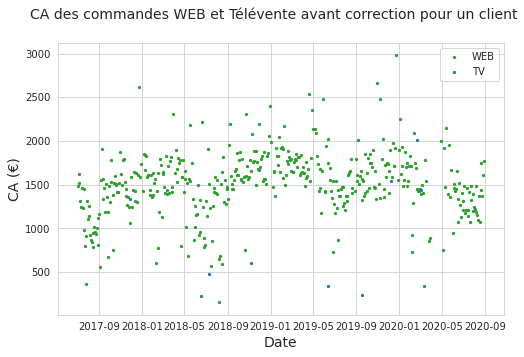

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[2],
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[0],
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('CA (€)', fontsize=14)
fig.suptitle('CA des commandes WEB et Télévente avant correction pour un client', fontsize=14)
ax.legend()


In [46]:
orders.to_pickle(persist_path / 'small_orders.pkl')

## Ajout de la segmentation et de la hiérarchie

On recharge le dataframe des commandes

In [47]:
orders = pd.read_pickle(persist_path / 'small_orders.pkl')

On ajoute quelques données du dataset client.

In [56]:
orders.index.get_level_values('client')

Index(['0000065940', '0000065945', '0000065975', '0000065998', '0000066014',
       '0000066020', '0000066022', '0000066024', '0000066026', '0000066029',
       ...
       '0000282373', '0000283953', '0000284089', '0000284540', '0000284735',
       '0000285226', 'SL001W', 'SL0041', 'SL0075', 'SL009N'],
      dtype='object', name='client', length=2444326)

In [57]:
df_clt.index.get_level_values('client')

Index(['0000022504', '0000026598', '0000134589', '0000136324', '0000150039',
       '0000173302', '0000183491', '0000213492', '0000261033', '0000282925',
       ...
       'ZZ001818', 'ZZ001819', '0000285557', '0000285560', '0000272709',
       '0000285560', '0000272709', '0000284904', '0000284904', '0000284904'],
      dtype='object', name='client', length=102323)

In [63]:
orders

margin  brutrevenue   weight  linecount origin2
orgacom date       client                                                     
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9      TV
                   0000065945    6.02        23.69    3.734          2      TV
                   0000065975   25.15        97.40   13.718          1      TV
                   0000065998    4.12         8.56    1.000          1      TV
                   0000066014   17.89        48.30    5.000          1      TV
...                               ...          ...      ...        ...     ...
2BRE    2020-08-31 0000285226  103.91       433.56   80.455         24      TV
                   SL001W       89.34       555.25  180.000          4      TV
                   SL0041       28.42      1470.00    7.200          1      TV
                   SL0075       12.76        95.03   15.615         11      TV
                   SL009N       10.51        75.03   40.500          1      TV

[2444326 rows x 5 columns]

REPRENDRE ICI

In [65]:
orders.reset_index('orgacom').astype({'orgacom': 'object'}).set_index('orgacom', append=True).reorder_levels(['orgacom', 'date', 'client'])

margin  brutrevenue   weight  linecount origin2
orgacom date       client                                                     
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9      TV
                   0000065945    6.02        23.69    3.734          2      TV
                   0000065975   25.15        97.40   13.718          1      TV
                   0000065998    4.12         8.56    1.000          1      TV
                   0000066014   17.89        48.30    5.000          1      TV
...                               ...          ...      ...        ...     ...
2BRE    2020-08-31 0000285226  103.91       433.56   80.455         24      TV
                   SL001W       89.34       555.25  180.000          4      TV
                   SL0041       28.42      1470.00    7.200          1      TV
                   SL0075       12.76        95.03   15.615         11      TV
                   SL009N       10.51        75.03   40.500          1      TV

[2444326 rows x 5 columns]

In [48]:
clt_fields = ['seg1', 'seg2', 'seg3', 'seg4', 'cat', 'sscat', 'hier4', 'groupecompte', 'relationtype', 'pilcom']
for field in clt_fields:
    try:
        orders = orders.drop(field)
    except: 
        pass
order_count = len(orders)
orders = orders.merge(df_clt.loc[:, clt_fields], left_on=['orgacom', 'client'], right_index=True, validate='m:1')
if len(orders) != order_count:
    raise RuntimeError('Something went wrong when merging orders with client master data!')

ValueError: Cannot set a Categorical with another, without identical categories

In [ ]:
orders

## Calcul des indicateurs composites

In [ ]:
composite_indicators_dict = utils.composite_indicators_dict

for indicator, components in composite_indicators_dict.items():
    try:
        orders[indicator] = orders[components[0]] / orders[components[1]]
    except KeyError:
        pass

orders = orders.reset_index()
orders['branch'] = orders['orgacom'].str[0].map({
    '1': 'PPF',
    '2': 'PES',
    }
)
orders.to_pickle(persist_path / 'small_full_orders.pkl')
orders

## Affichage des indicateurs sur l'année 2019

In [ ]:
reload(utils)

In [ ]:
orders = pd.read_pickle(persist_path / 'small_full_orders.pkl')

In [ ]:
show(partial(utils.bk_histo_seg,
             source_df=orders.reset_index(),
             segs=['seg1', 'seg2'],
             filters={},
             filters_exclude={'groupecompte': ['ZPER']}, # 'hier4': ['198863']
             plot_kwargs=dict(title="Chiffre d'affaire brut 2019 en fonction de la segmentation niveau 2 et du canal"),
            ),
     notebook_url="http://devdm:8888")

In [ ]:
show(partial(utils.bk_histo_seg,
             source_df=orders.reset_index(),
             segs=['seg2', 'seg3'],
             filters={'seg1': ['Z3']},
             filters_exclude={}, #'hier4': ['198863']
             plot_kwargs=dict(title="Chiffre d'affaire brut 2019 RHD en fonction de la segmentation niveau 3 et du canal"),
            ),
     notebook_url="http://devdm:8888") #'seg1': ['Z3']

## Affichage des distributions - par succursale

In [ ]:
filter_otacos = (orders.hier4 != '198863')
filter_personnel = (orders.groupecompte != 'ZPER')
filter_rhd = (orders.seg1 == 'Z3')
filter_ppf = (orders.branch == 'PPF')
filter_pes = (orders.branch == 'PES')
filter_main_origins = ~(
    (orders.origin2.isin(['EDI']) & orders.seg3.isin(['ZI', 'ZK'])) |
    (orders.origin2.isin(['VR']) & orders.seg3.isin(['ZJ', 'ZL'])) |
    (orders.origin2.isin(['WEB']) & orders.seg3.isin(['ZJ']))
)
print(f"Filtrage des origines de commandes minoritaires : \n",
      f"Avant filtration il y avait {len(orders)} commandes\n",
      f"Après filtration il reste {sum(filter_main_origins)} commandes\n",
      f"Soit un delta de {len(orders) - sum(filter_main_origins)} commandes",
      f'({(len(orders) - sum(filter_main_origins)) / len(orders):.2%})',
      )

In [ ]:
%%time
indicators2 = ['margin', 'brutrevenue',  'PMVK', 'linecount', 'marginperkg', 'weight', 'marginpercent', 'lineweight']
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue=None,
                              hue_order=None,
                              translate=['xaxis', 'indicator',],                              
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par succursale', fontsize=16, y=.91)

In [ ]:
utils.pretty_means(data=orders.reset_index(), groupers=['orgacom'], indicators=indicators2)

## Affichage des distributions - par canal de vente

In [ ]:
%%time

filters = filter_personnel

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=filters,
                              ncols=2,
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=True,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
fig.suptitle('Analyse des commandes par canal - Hors commandes personnel', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[filters].reset_index(),
                   groupers=['branch', 'origin2'],
                   indicators=indicators2,
                   translate=['branch', 'columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente - hors O'Tacos

In [ ]:
%%time

filters = filter_personnel & filter_otacos

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=filters,
                              ncols=2,
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=True,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[filters].reset_index(),
                   groupers=['branch', 'origin2'],
                   indicators=indicators2,
                   translate=['branch', 'columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente - uniquement O'Tacos

In [ ]:
%%time
fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=(~filter_otacos) & (orders.origin2 != 'VR'),
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'x', 'indicator'],
                              hue=None,
                              hue_order=None,
                              kind='violin',
                              percentile_selection=1.,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[~filter_otacos].reset_index(),
                   groupers=['origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente et succursale

In [ ]:
%%time

filters = filter_personnel

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=filters,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator',],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=None,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle('Analyse des commandes par canal et par succursale', fontsize=16, y=.91)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
utils.pretty_means(data=orders.loc[filters].reset_index(),
                   groupers=['orgacom', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente et succursale - Hors O'Tacos

In [ ]:
%%time

filters = filter_personnel & filter_otacos

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=filters,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator',],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=None,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et par succursale - Hors O'Tacos", fontsize=16, y=.91)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
utils.pretty_means(data=orders.loc[filters].reset_index(),
                   groupers=['orgacom', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par segment

In [ ]:
reload(utils)

In [ ]:
filters = filter_rhd & filter_personnel

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=(filters),
                              ncols=2,
                              hue='seg3',
                              hue_order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=['xaxis', 'indicator', 'x', 'legend'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
handles, labels = axs[0, 0].get_legend_handles_labels()
labels = map(partial(utils.lib, domain='seg3'), labels)
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
fig.suptitle("Analyse des commandes par segment de restauration", fontsize=16, y=.91)
utils.pretty_means(data=orders[filters].reset_index(),
                   groupers=['branch', 'seg3'],
                   indicators=indicators2,
                   translate=['branch', 'columns', 'seg3']
                  )

## Affichage des distributions - par segment - Hors O'Tacos

In [ ]:
filters = filter_rhd & filter_personnel & filter_otacos

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=(filters),
                              ncols=2,
                              hue='seg3',
                              hue_order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=['xaxis', 'indicator', 'x', 'legend'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
handles, labels = axs[0, 0].get_legend_handles_labels()
labels = map(partial(utils.lib, domain='seg3'), labels)
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
fig.suptitle("Analyse des commandes par segment de restauration - Hors O'Tacos", fontsize=16, y=.91)
utils.pretty_means(data=orders[filters].reset_index(),
                   groupers=['branch', 'seg3'],
                   indicators=indicators2,
                   translate=['branch', 'columns', 'seg3']
                  )

## Affichage des distributions, par segment et canal de commande - PassionFroid

In [ ]:
filters = filter_rhd & filter_main_origins & filter_ppf

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filters),
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
#                               IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par segment de restauration et par canal - PassionFroid", fontsize=16, y=.91)
utils.pretty_means(data=orders[filters].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'seg3', 'origin2']
                  )
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

## Affichage des distributions, par segment et canal de commande - EpiSaveurs

In [ ]:
filter_rhd = (orders.seg1 == 'Z3')

filters = filter_rhd & filter_main_origins & filter_pes

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filters),
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
#                               IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par segment de restauration et par canal - EpiSaveurs", fontsize=16, y=.91)
utils.pretty_means(data=orders[filters].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'seg3', 'origin2']
                  )
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

## Affichage des distributions, par segment et canal de commande - Hors O'Tacos - PassionFroid

In [ ]:
filters = filter_rhd & filter_main_origins & filter_ppf & filter_otacos

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filters),
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
#                               IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle(
    "Analyse des commandes par segment de restauration et par canal - Hors O'Tacos- PassionFroid",
    fontsize=16,
    y=.91
)
utils.pretty_means(data=orders[filters].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'seg3', 'origin2']
                  )
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

## Focus sur le PMVK en RCS

In [ ]:
filter_rhd = (orders.seg1 == 'Z3')
filter_rcs = (orders.seg3 == 'ZL')

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rcs & filter_main_origins),
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
#                               x='seg3',
#                               order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - Focus RCS", fontsize=16, y=.91)
# utils.pretty_means(data=orders[filter_rhd & filter_otacos].reset_index(),
#                    groupers=['seg3', 'origin2'],
#                    indicators=indicators2,
#                    translate=['columns', 'seg3', 'origin2']
#                   )
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
# for ax_list in axs:
#     for ax in ax_list:
#         for x in [.5, 1.5, 2.5]:
#             ax.axvline(x, lw=1, color='grey', alpha=.5)
#         ax.get_legend().remove()

In [ ]:
filter_rhd = (orders.seg1 == 'Z3')
filter_rcs = (orders.seg3 == 'ZL')

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rcs & filter_main_origins),
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - Focus RCS", fontsize=16, y=.91)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
#         for x in [.5, 1.5, 2.5]:
#             ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

In [ ]:
orders['otacos'] = filter_otacos.map({True: 'nonotacos', False: 'otacos'})

In [ ]:
filter_rhd = (orders.seg1 == 'Z3')
filter_rcs = (orders.seg3 == 'ZL')

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rcs & filter_main_origins),
                              ncols=2,
                              hue='otacos',
                              hue_order=['nonotacos', 'otacos'],
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - Focus RCS", fontsize=16, y=.91)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
#         for x in [.5, 1.5, 2.5]:
#             ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

## Impact du Web sur les indicateurs, à la maille du client

On calcule le zscore sur les indicateurs suivis, **à la maille du client DO**.

In [ ]:
orders = pd.read_pickle(persist_path / 'full_orders.pkl')

In [ ]:
orders = compute_zscores(orders,
                         grouper_fields=['orgacom', 'client'],
                         indicators=indicators2)

Pour un client donné, cela ne change pas le rapport entre les divers indicateurs :

In [ ]:
sample = orders.reset_index().loc[orders.reset_index().origin2 == 'WEB'].sample(1).iloc[0]

In [ ]:
oc, client = '1SOU', '0000067029' #sample.orgacom, sample.client
name = df_clt.loc[(oc, client), 'nom']
print(f'{client} - {name}')
fig, axs = plt.subplots(figsize=(8, 18), nrows=4)
mask_clt = (orders.reset_index().client == client)
mask_web = mask_clt & (orders.reset_index().origin2 == 'WEB')
mask_other = mask_clt & (orders.reset_index().origin2 != 'WEB')
col_web = list(mcolor.TABLEAU_COLORS.values())[2]
col_tv = list(mcolor.TABLEAU_COLORS.values())[0]
(orders.reset_index()
       .loc[mask_other]
       .rename({'margin': 'Marge (€)',
                'brutrevenue': 'CA brut (€)'}, axis=1)
       .plot(kind='scatter', y='Marge (€)', x='CA brut (€)', color=col_tv, ax=axs[2], label='TV')
)
(orders.reset_index()
       .loc[mask_web]
       .rename({'margin': 'Marge (€)',
                'brutrevenue': 'CA brut (€)'}, axis=1)
       .plot(kind='scatter', y='Marge (€)', x='CA brut (€)', color=col_web, ax=axs[2], label='WEB')
)

(orders.reset_index()
       .loc[mask_other]
       .rename({'margin_clt_zscore': 'Marge (€) - z-score',
                'brutrevenue_clt_zscore': 'CA brut (€) - z-score'}, axis=1)
       .plot(kind='scatter', y='Marge (€) - z-score', x='CA brut (€) - z-score', color=col_tv, ax=axs[3], label='TV')
)
(orders.reset_index()
       .loc[mask_web]
       .rename({'margin_clt_zscore': 'Marge (€) - z-score',
                'brutrevenue_clt_zscore': 'CA brut (€) - z-score'}, axis=1)
       .plot(kind='scatter', y='Marge (€) - z-score', x='CA brut (€) - z-score', color=col_web, ax=axs[3], label='WEB')
)

axs[3].scatter(x=[0], y=[0], marker='s', color='black')
orders.reset_index().loc[mask_clt].plot(kind='line', y='margin', x='date', color='black', ax=axs[0])
orders.reset_index().loc[mask_clt].plot(kind='line', y='margin_clt_zscore', x='date', color='black', ax=axs[1])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[0].set_ylabel('Marge (€)', fontsize=14)
axs[1].set_ylabel('Marge (€) - z-score', fontsize=14)
axs[2].set_ylabel('Marge (€)', fontsize=14)
axs[3].set_ylabel('Marge (€) - z-score', fontsize=14)
axs[2].set_xlabel('CA brut (€)', fontsize=14)
axs[3].set_xlabel('CA brut (€) - z-score', fontsize=14)
axs[2].legend()
axs[3].legend()
fig.tight_layout()

### Création d'un exemple fictif

On crée un exemple fictif pour illustrer.

In [ ]:
def dt_linspace(start, end, n):
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    t = np.linspace(start.value, end.value, n)
    t = pd.to_datetime(t)
    return(t)
t1 = dt_linspace('2019-01-01', '2019-03-31', 10)
type(t1)

In [ ]:
palette = [
    list(mcolor.TABLEAU_COLORS.values())[0],
    list(mcolor.TABLEAU_COLORS.values())[2],
]

len_clt1 = 50
clt1_origin = ['TV'] * len_clt1
web_clt1_indices = [12, 36]
for idx_ in web_clt1_indices:
    clt1_origin[idx_] = 'WEB'


ex_df = [
    pd.DataFrame(
        {
            'client': ['clt1'] * len_clt1,
            'date': dt_linspace('2019-01-01', '2019-03-31',len_clt1),
            'origin': clt1_origin,
            'margin': np.random.normal(size=len_clt1) + [10] * len_clt1,
        }
    ),
    pd.DataFrame(
        {
            'client': ['clt2'] * 15,
            'date': dt_linspace('2019-01-01', '2019-03-22', 15),
            'origin': ['TV'] * 7 + ['WEB'] * 8,
            'margin': np.random.normal(size=15) + ([25] * 7 + [20] * 8),
        }
    )
]
ex_df = pd.concat(ex_df)
ex_df = utils.compute_zscores(ex_df, indicators=['margin'], grouper_fields=['client'])
# sns.scatterplot(data=ex_df, x='date', y='margin', hue=ex_df.origin.to_list(),
#                 palette=palette,
#                 style=ex_df.origin.to_list(),
#                )

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(8,10), sharex=True)
to_plot = ex_df.loc[ex_df.client == 'clt1']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[0],
               )
to_plot = ex_df.loc[ex_df.client == 'clt2']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[1],
               )
axs[1].set_ylim(0)
axs[0].set_ylim(0, axs[1].get_ylim()[1])
axs[0].set_title('Marge du client 1', fontsize=14)
axs[1].set_title('Marge du client 2', fontsize=14)
axs[1].set_xlabel(None)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
for ax in axs:
    ax.set_ylabel('Marge (€)', fontsize=14)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
to_plot = ex_df
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=ax,
               )
ax.set_title('Marges des clients 1 et 2', fontsize=14)
ax.set_xlabel(None)
ax.set_ylim(0)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
ax.set_ylabel('Marge (€)', fontsize=14)

In [ ]:
fig, axs = utils.plot_distrib(
    data=ex_df, 
    ncols=2,
    indicators=['margin', 'margin_clt_zscore'],
    x='origin',
    order=['TV', 'WEB'],
    kind='violin',
    percentile_selection=0.99,
    IQR_factor_selection=3.0,
    IQR_factor_plot=None,
    show_means=True,
    plot_kwargs=dict(palette=palette, cut=4.),
    translate=True,
    fontsizes_kwargs=None,    
)
axs[0, 0].set_ylim(0, ax.get_ylim()[1])
axs[0, 1]

In [ ]:
utils.pretty_means(data=ex_df,
                   groupers=['origin'],
                   indicators=['margin', 'margin_clt_zscore'],
                   translate=['columns', 'origin']
                  )

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(8,10), sharex=True)
to_plot = ex_df.loc[ex_df.client == 'clt1']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[0],
               )
to_plot = ex_df.loc[ex_df.client == 'clt2']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[1],
               )
axs[0].set_title('Marge du client 1 - z-score', fontsize=14)
axs[1].set_title('Marge du client 2 - z-score', fontsize=14)
axs[1].set_xlabel(None)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
for ax in axs:
    ax.set_ylabel('Marge (€)', fontsize=14)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
to_plot = ex_df
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=ax,
               )
ax.set_title('Marges des clients 1 et 2 - z-score', fontsize=14)
ax.set_xlabel(None)
# ax.set_ylim(0)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
ax.set_ylabel('Marge (€) - z-score', fontsize=14)

In [ ]:
df_sample = pd.concat([orders.loc[orders.origin2 == origin].sample(100) for origin in orders.origin2.unique()], axis=0)

fig, axs = plt.subplots(nrows=2, figsize=(8, 15))
sns.scatterplot(data=df_sample, x='brutrevenue', y='margin', hue=df_sample.origin2.tolist(), ax=axs[0])
sns.scatterplot(data=df_sample, x='brutrevenue_clt_zscore', y='margin_clt_zscore', hue=df_sample.origin2.tolist(), ax=axs[1])

## Affichage des indicateurs en zscore par canal

In [ ]:
indicators_zscore = [indicator + '_clt_zscore' for indicator in indicators2]

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=['xaxis', 'indicator', 'x', ],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.3,
                              show_means=True,
                              plot_kwargs=dict(whis=1.5),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - z-score", fontsize=16, y=.91)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
#         for x in [.5, 1.5, 2.5]:
#             ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

utils.pretty_means(data=orders.reset_index(),
                   groupers=['branch', 'origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'origin2', 'branch']
                  )

## Affichage des indicateurs en zscore par canal et succursale

In [ ]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', ],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et succursale - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

utils.pretty_means(data=orders.reset_index(),
                   groupers=['orgacom', 'origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'origin2']
                  )

## Affichage des indicateurs en zscore par canal et par segment - PassionFroid

In [ ]:
filters = filter_main_origins & filter_ppf
filters_means = filter_rhd & filter_ppf

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=filters,
                              ncols=2,
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et segment - PassionFroid - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)        
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
        
    
utils.pretty_means(data=orders.loc[filters_means].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'seg3', 'origin2']
                  )

## Affichage des indicateurs en zscore par canal et par segment - PassionFroid

In [ ]:
filters = filter_main_origins & filter_pes
filters_means = filter_rhd & filter_pes

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=filters,
                              ncols=2,
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et segment - EpiSaveurs - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)        
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
        
    
utils.pretty_means(data=orders.loc[filters_means].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'seg3', 'origin2']
                  )

## Affichage des indicateurs en zscore par canal et par segment - hors EDI et SDR

**ATTENTION !!!** Cet indicateur devrait être recalculé, car la filtration du canal EDI filtre une partie des commandes d'un client et donc le zscore n'est plus bon.

In [ ]:
filter_not_edi = ~orders.origin2.isin(['EDI'])
filter_not_sdr = ~orders.seg3.isin(['ZJ'])

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=(filter_otacos & filter_not_edi & filter_not_sdr & filter_rhd),
                              ncols=2,
                              x='seg3',
                              order=['ZI', 'ZK', 'ZL'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et segment (hors O'Tacos, SDR et EDI) - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
        

## Analyse comportementale, première modélisation : bascule à la première commande Web


# WIP WIP WIP WIP

In [ ]:
def comp_thresh(val, thresholds):
    '''
    Thresholds are (low, high): target
    They must be sorted in ascending order
    '''
    for low_high, target in thresholds.items():
        if val < low_high[0]:
            return(None)
        if val <= low_high[1]:
            return(target)
    return(None)

In [ ]:
def hyst_from_thresh(ds, thresholds=None, initial=None):
    ret = pd.Series(index=ds.index, dtype='object')
    for i, val in enumerate(ds): 
#         print(i, val)
        target = comp_thresh(val, thresholds)
        if target is not None: 
            ret.iloc[i] = target
        else:
            if i == 0:
                ret.iloc[0] = initial
            else:
                ret.iloc[i] = ret.iloc[i-1]
    return(ret)

In [ ]:
len(orders)

In [ ]:
orders.margin.tail()

In [ ]:
%%time
orders['margin'].groupby(['orgacom', 'client']).transform(lambda x: hyst_from_thresh(x, thresholds=thresholds ,initial='DEFAULT'))

In [ ]:
%%time
hyst_from_thresh(orders.margin, thresholds=thresholds ,initial='DEFAULT')

In [ ]:
toto = orders.head(5000).margin.groupby(['orgacom', 'client']).rolling(5, win_type='triang', min_periods=1).mean()
toto

In [ ]:
orders.index.get_level_values(1).unique()

In [ ]:
orders.xs(('1SOU', '0000065940')).margin.plot(kind='line')
(
pd.DataFrame(toto.reset_index().level_2.to_list(), index=toto.index).join(toto).reset_index(drop=True)
    .set_index([0, 1, 2]).xs(('1SOU', '0000065940')).plot(kind='line')
)

In [ ]:
orders.head(50).margin

# WIP WIP WIP WIP

Dans un premier temps, on va considérer que la bascule se fait à la première commande Web. Les hypothèses sont : 
- le statut est initialement le canal de la première commande
- ensuite, il est 'WEB' à partir de la première commande web

On commence par calculer le statut initial de chaque client

In [ ]:
try:
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )
except KeyError: 
    orders = orders.reset_index()
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )    

On initialise la table des mises à jour de statuts :

In [ ]:
status_updates = (
    orders[['orgacom',
            'client',
            'date',
            'origin2']].merge(first_order,
                              on=['orgacom', 'client', 'date'],
                              how='inner',
                              validate='1:1')
                       .rename({'origin2': 'new_stat'}, axis=1)
                       .set_index(['orgacom', 'client', 'date'])
)

On complète en ajoutant la première commande WEB (si elle n'est pas également la première commande).

In [ ]:
status_updates2 = (
orders.loc[orders.origin2 == 'WEB']
      .groupby(['client', 'orgacom'], observed=True)['date']
      .min()
      .reset_index()
      .set_index(['orgacom', 'client', 'date'])
)
status_updates2['new_stat'] = 'WEB'
status_updates = (status_updates.append(status_updates2.loc[~status_updates2.index.isin(status_updates.index)])
                                .sort_values(['orgacom', 'client', 'date'])
                 )
status_updates = status_updates.sort_index()
del(status_updates2)
if len(status_updates.loc[status_updates.index.duplicated(keep=False)]) > 0.:
    raise RuntimeError('Something went wrong in computing statuses!')

In [ ]:
status_updates

On rappatrie le statut calculé depuis la tables des mises à jour de statut (`status_updates`) dans la table des commandes (`orders`).

In [ ]:
statuses = (
    status_updates.reindex(status_updates.index.union(orders.set_index(['orgacom', 'client', 'date']).index))
                  .sort_index()
                  .fillna(method='ffill')
                  .rename({'new_stat': 'clt_stat'}, axis=1)
)

try:
    del(orders['clt_stat'])
except KeyError:
    pass       

orders2 = (
orders.set_index(['orgacom', 'client', 'date'])
      .merge(statuses, left_index=True, right_index=True, how='left', indicator=True, validate='1:1')
) 
    
if len(orders2.loc[orders2._merge != 'both']) > 0: 
    raise RuntimeError('Something went wrong during statuses computation')
if len(orders2) != len(orders):
    raise RuntimeError('Something went wrong during statuses computation')
orders = orders2
del(statuses)
del(orders['_merge'])

In [ ]:
orders.sample(5)

On rappatrie ensuite de quoi calculer les indicateurs dans la table des mises à jour de statut.

In [ ]:
(
orders.groupby(['orgacom', 'client', 'clt_stat'], observed=True)
      .agg({'margin': 'sum',
            'brutrevenue': 'sum', 
            'weight': 'sum', 
            'linecount': 'sum', 
            'origin2': 'size',
           })
      .rename({'origin2': 'ordercount'}, axis=1)
)

In [ ]:
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'new_stat']).join(
    orders.rename({'clt_stat': 'new_stat'}, axis=1)
          .groupby(['orgacom', 'client', 'new_stat'], observed=True)
          .agg({'margin': 'sum',
                'brutrevenue': 'sum', 
                'weight': 'sum', 
                'linecount': 'sum', 
                'origin2': 'size',
               })
          .rename({'origin2': 'ordercount'}, axis=1)         
)
status_updates

In [ ]:
status_updates['PMVK'] = status_updates.brutrevenue / status_updates.weight
status_updates['marginperkg'] = status_updates.margin / status_updates.weight
status_updates['marginpercent'] = status_updates.margin / status_updates.brutrevenue
status_updates['lineweight'] = status_updates.weight / status_updates.linecount
for indicator in ['margin', 'brutrevenue', 'weight', 'linecount']:
    status_updates[indicator] /= status_updates['ordercount']
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'date'])
status_updates

In [ ]:
orders

In [ ]:
status_updates = compute_zscores(status_updates, ['orgacom', 'client'], indicators2)

In [ ]:
fig, axs = utils.plot_distrib(data=status_updates.reset_index(),
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              hue=None,
                              hue_order=None,
                              x='new_stat',
                              order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.8,
                              show_means=True,
                              plot_kwargs=dict(whis=1.5),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Comparatif des différences avant/après la première commande WEB", fontsize=16, y=.91)

utils.pretty_means(data=status_updates.reset_index(),
                   groupers=['new_stat'],
                   indicators=indicators2,
                   translate=['columns', 'new_stat']
                  )

In [ ]:
fig, axs = utils.plot_distrib(data=orders,
                              filter=filter_otacos, 
                              indicators=['PMVK', 'PMVK_clt_zscore'],
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='orgacom', #'origin2', 
                              order=['2BRE', '1ALO', '1LRO', '1SOU',],
                              kind='boxplot',
                              percentile_selection=.98,
                              IQR_factor_selection=1.5,
                              IQR_factor_plot=1.,
                              show_means=True,
                              translate=['xaxis', 'indicator'],
                             )

In [ ]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              hue=None,
                              hue_order=None,
                              x='clt_stat',
                              order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.8,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Comparatif des différences avant/après la première commande WEB - commandes", fontsize=16, y=.91)

utils.pretty_means(data=orders.reset_index(),
                   groupers=['clt_stat'],
                   indicators=indicators2,
                   translate=['columns', 'clt_stat']
                  )

In [ ]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='clt_stat',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator',],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.3,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Comparatif des différences avant/après la première commande WEB - commandes", fontsize=16, y=.91)

utils.pretty_means(data=orders.reset_index(),
                   groupers=['orgacom', 'clt_stat',],
                   indicators=indicators_zscore,
                   translate=['columns', 'clt_stat']
                  )

## Plot des détails

In [ ]:
colors = {'TV': 'blue', 'VR': 'orange', 'WEB': 'green'}
sample_clt = (
# '0000210861'
# '0000020511'
'0000020697'
)
to_plot = orders.loc[idx[:, sample_clt, :]].copy()
to_plot['color'] = to_plot['origin2'].map(colors)
to_plot

In [ ]:
status_plot = status_updates.loc[idx[: , sample_clt, :]]
status_plot

In [ ]:
ind_ = 'brutrevenue'

p = figure(x_axis_type="datetime", title='Détail pour ' + sample_clt + " - " + ind_, plot_height=500, plot_width=800)
first_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[0],
#                           bottom=0.,
                          right=status_plot.index.get_level_values('date')[1],
                          fill_color='blue',
                          fill_alpha=.2,
                         )
p.add_layout(first_box)
second_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[1],
#                            bottom=0.,
#                            right=status_plot.index.get_level_values(2)[1],
                           fill_color='green',
                           fill_alpha=.2,
                          )

p.add_layout(second_box)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[0]) * 1000,
      y=(status_plot[ind_]).iloc[0],
      angle=0.,
      length=(datetime.timestamp(status_plot.index.get_level_values('date')[1]) - datetime.timestamp(status_plot.index.get_level_values('date')[0])) * 1000,
      line_color='blue',
      line_width=2)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[1]) * 1000,
      y=(status_plot[ind_]).iloc[1],
      angle=0.,
      length=0,
      line_color='green',
      line_width=2)
p.circle(to_plot.index.get_level_values('date'), to_plot[ind_], color=to_plot.color)
show(p)

In [ ]:
orders = orders.sort_index()

In [ ]:
orders.loc[('1SOU', '0000065940'), ['margin', 'brutrevenue']]

Pour le calcul d'une rentabilité par unité de temps, bien penser à resampler le datetime index AVANT de faire le rolling (cf. ci dessous)

In [ ]:
    (orders.loc[('1ALO', '0000020697'), ['margin', 'brutrevenue']]
          .rolling(30, win_type='triang', center=True)     
          .mean()
    ).plot(kind='line')


In [ ]:
orders

In [ ]:
orders.loc[('1SOU', '0000065940')]

In [ ]:
orders

In [ ]:
orders.loc[('1SOU', '0000010078')]

In [ ]:
orders = pd.read_pickle(persist_path / 'orders.pkl')
orders

In [ ]:
to_process = (
orders[['weight', 'margin', 'brutrevenue', 'origin2']].rename_axis('indicators', axis=1)
    .reset_index().astype({'orgacom': 'object', 'origin2': 'object'})
    .set_index(['orgacom', 'client', 'date', 'origin2']).unstack('origin2', fill_value=0)
    .reset_index().set_index('date')
)
to_process

**Solution 1**

In [ ]:
# %%time
# sol1 = (
# to_process.groupby(['orgacom', 'client'], observed=True, )
#           .apply(lambda x: x.asfreq('B', fill_value=np.nan))
# )
# sol1

**Solution 2**

In [ ]:
# %%time
# sol2 = (
# to_process.groupby(['orgacom', 'client'], observed=True, )
#     .apply(lambda x: x.reindex(pd.date_range(x.index.min(), x.index.max(), freq='B'), fill_value=np.nan))
# )
# sol2

**Solution 3**

In [ ]:
def create_params(df):
    return (df.reset_index().groupby(['orgacom', 'client'], observed=True, )['date']
            .agg(['min', 'max']).sort_index().reset_index())

def create_multiindex(df, params):
    all_dates = pd.date_range(start='2016-12-31', end='2020-12-31', freq='B')
    midx = (
        (row.orgacom, row.client, d)
        for row in params.itertuples()
        for d in all_dates[(row.min <= all_dates) & (all_dates <= row.max)])
    return pd.MultiIndex.from_tuples(midx, names=['orgacom', 'client', 'date'])

def apply_mulitindex(df, midx):
    return df.set_index(['orgacom', 'client', 'date']).reindex(midx, fill_value=0.)

def new_pipeline(df):
    params = create_params(df)
    midx = create_multiindex(df, params)
    return apply_mulitindex(df, midx)

In [ ]:
%%time
day_orders = new_pipeline(to_process.reset_index())
day_orders

**Solution 4**

In [ ]:
# %%time
# sol4 = to_process.groupby(['orgacom', 'client']).resample('B').asfreq()
# sol4

**Solution initiale**

In [ ]:
# %%time
# day_orders = (
# orders[['weight', 'margin', 'brutrevenue', 'origin2']].rename_axis('indicators', axis=1)
#     .reset_index().astype({'orgacom': 'object', 'origin2': 'object'})
#     .set_index(['orgacom', 'client', 'date', 'origin2']).unstack('origin2', fill_value=0)
#     .reset_index().set_index('date')
#     .groupby(['orgacom', 'client'], observed=True, )
#     .apply(lambda x: x.asfreq('B', fill_value=np.nan))
#     .drop(['orgacom', 'client'], axis=1)
#     .fillna(0.)
# #     .unstack('origin2', fill_value=0)
# #     .groupby('indicators', axis=1)
# #     .sum()
# )
# day_orders

In [ ]:
day_orders.to_pickle(persist_path / 'small_day_order.pkl')

In [ ]:
%%time
day_orders.join(
    pd.concat([day_orders.groupby('indicators', axis=1).sum()], keys=['total'], names=['origin2'], axis=1)
      .swaplevel(axis=1)
).sort_index(axis=1)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
orders = pd.read_pickle(persist_path / 'orders.pkl')
orders

In [ ]:
%%time
with pd.option_context('display.max_rows', None):
    (
    orders.loc[('1ALO', '0000020697'), ['margin', 'brutrevenue']]
          .asfreq('B', fill_value=0)
          .rolling(30, win_type='triang', center=True)
          .mean()
    ).plot(kind='line')
    

In [ ]:
status_updates

In [ ]:
data.loc[data.client == '0000020575']

In [ ]:
status_updates

In [ ]:
status_updates['end_date'] = status_updates.reset_index().groupby(['orgacom', 'client'])['date'].shift(-1)

In [ ]:
status_updates.reset_index(inplace=True)

In [ ]:
status_updates

In [ ]:
status_updates.groupby(['orgacom', 'client'])['date'].shift(-1)

In [ ]:
status_updates['end_date'] = (
    status_updates.groupby(['orgacom', 'client'])['date']
                  .shift(-1, fill_value=np.nan)
)

In [ ]:
status_updates.end_date - status_updates.date

In [ ]:
for indicator in indicators2:
    status_update[indicator] = 

In [ ]:
with pd.option_context('display.max_rows', None):
    print(status_updates.head(100))

## Données de base article

In [ ]:
matfields = {'code article':'object',
              'libellé article':'category',
              'code gamme':'category',
              'libellé gamme':'category', 
              'MARC-MMSTA':'category',
              'MARC-LVORM':'category',
              'MVKE-LVORM':'category',
              'MVKE-MVSTA':'category',
              'MARA-LVORM':'category',
              'Hiérarchie produit':'object',
              'Type d\'article':'category',
              'Division':'object', 
              'Org. commerciale':'category', 
              'Canal distribution':'category',
              'File d\'achat':'category', 
              'Marque industrielle':'category', 
              'Marque commerciale':'category', 
              'Grpe de marchandises':'category', 
              'Poids net':'float', 
              'Unité de p':'category',
              'V1':'category',
              'V2':'category',
              'V3':'category',
              'LG1':'category',
              'LG2':'category',         
             }

df_mat = pd.read_csv(Path('..') / 'data' / 'Référentiel_ConverteO_1ALO_Art_20191209.csv', 
                     sep=';', 
                     header=0, 
                     encoding="ISO-8859-1", 
                     dtype=matfields,
                     decimal=",")
df_mat.sample(5)

In [ ]:
num_mat_mask = df_mat['code article'].str.isnumeric()
df_mat.loc[num_mat_mask, 'code article'] = df_mat.loc[num_mat_mask, 'code article'].str.zfill(18)
df_mat.set_index('code article', inplace=True, drop=True)
df_mat.sample(5)

In [ ]:
if sum(df_mat.index.duplicated()):
    raise RuntimeError('Something went wrong on the material dataframe! Some indices are duplicated!')

# Feature engineering et nettoyage
## Fusion des datasets
### Ajout des données articles
On ajoute dans un premier temps les données article.

In [ ]:
data2 = (
data.merge(df_mat, how='left', left_on='material', right_index=True, validate='many_to_one', indicator=True)
)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données article.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some materials are missing in material master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un code article est en double dans les master data article).

In [ ]:
if len(data2) != len(data):
    raise RuntimeError('Looks like there were duplicate material numbers in material master data!')
data = data2
del data2
data.sample(5)

### Ajout des données client
On commence par fusionner les datasets.

In [ ]:
data2 = data.merge(df_clt,
                   how='left',
                   left_on=['orgacom', 'client'],
                   right_index=True,
                   validate='many_to_one',
                   indicator=True)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données client.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some clients are missing in client master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un couple (orgacom x client) est en double dans les master data client).

In [ ]:
if len(data2) != len(data):
    print('Looks like there were duplicate orgacom x client keys in client master data!')
data = data2
del data2
data.sample(5)